### TRIAPPGE: Primeros Pasos

In [2]:
from utils import *

En un principio iba a usar como dataset principal [FracAtlas](https://www.nature.com/articles/s41597-023-02432-4). Y aunque lo acabaremos usando, vamos a ver porqué no lo hemos utilizado en una primera fase de dearrollo.

In [3]:
images_atlas, labels_atlas = load_dataset_split('data/original/FracAtlas')

In [4]:
np.unique(labels_atlas, return_counts=True)

(array([0, 1]), array([3366,  717], dtype=int64))

Nos encontramos ante un dataset no balanceado (0=Imagenes sin fractura, 1=con fractura), por lo que vamos a tomar otro dataset como punto de partida. Para ello recurrimos a Kaggle, y un dataset bastante balanceado con imagenes ya rotadas que ayudarán a nuestro modelo.

In [5]:
train_images, train_labels = load_dataset_split('data/original/balanced/train')
val_images, val_labels = load_dataset_split('data/original/balanced/val')
test_images, test_labels = load_dataset_split('data/original/balanced/test')


In [6]:
images_balanced = np.concatenate([train_labels, val_labels, test_labels])
np.unique(images_balanced, return_counts=True)

(array([0, 1]), array([2455, 2445], dtype=int64))

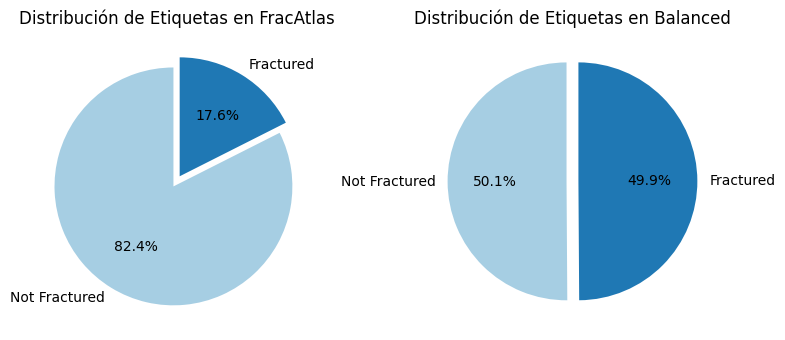

''

In [7]:
label_map = {0: "Not Fractured", 1: "Fractured"}

labels1, counts1 = np.unique(labels_atlas, return_counts=True)
labels2, counts2 = np.unique(images_balanced, return_counts=True)

labels1 = [label_map[label] for label in labels1]
labels2 = [label_map[label] for label in labels2]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

explode1 = [0.05] * len(labels1)
explode2 = [0.05] * len(labels2)

# Gráfico 1
axes[0].pie(
    counts1, labels=labels1, autopct='%1.1f%%', startangle=90,
    explode=explode1, colors=plt.cm.Paired.colors
)
axes[0].set_title("Distribución de Etiquetas en FracAtlas")

# Gráfico 2
axes[1].pie(
    counts2, labels=labels2, autopct='%1.1f%%', startangle=90,
    explode=explode1, colors=plt.cm.Paired.colors
)
axes[1].set_title("Distribución de Etiquetas en Balanced")

plt.tight_layout()
plt.show()
;

Siendo este dataset nuestro punto de partida, arrancamos con un primer modelo de tensorflow (binary_mode_v1_balanced.ipynb), y al implementarlo para testear con imagenes de FracAtlas me doy cuenta de algo importante. El dataset no contempla muchas imágenes de rodillas o de otras articulaciones y al ver espacios, así que hacemos oversampling de las imagenes de fracturas de FracAtlas mediante copias rotadas.

In [ ]:
import os
import cv2
import numpy as np

# Ruta de las imágenes originales
#input_dir = "FracAtlas/FracAtlas/images/Fractured"
#output_dir = "FracAtlas/FracAtlas/images/Fractured_Augmented"


os.makedirs(output_dir, exist_ok=True)


angles = [-20, -10, 10, 20, 30]


def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return rotated


for filename in os.listdir(input_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
      
        img_path = os.path.join(input_dir, filename)
        image = cv2.imread(img_path)

       
        cv2.imwrite(os.path.join(output_dir, filename), image)

     
        for angle in angles:
            rotated_image = rotate_image(image, angle)
            new_filename = f"{os.path.splitext(filename)[0]}_rot{angle}.jpg"
            cv2.imwrite(os.path.join(output_dir, new_filename), rotated_image)

print("Proceso de aumento de datos completado")


Y redistribuimos siguiendo la proporción de Train, Val, Test (80/10/10)

In [ ]:
import os
import shutil
import random

base_dir = "FracAtlas"
output_dirs = ["train", "val", "test"]
classes = ["Fractured", "Not Fractured"]

split_ratios = {"train": 0.8, "val": 0.1, "test": 0.1}

for output_dir in output_dirs:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, output_dir, class_name), exist_ok=True)


def split_and_move_images(class_name):

    class_dir = os.path.join(base_dir, class_name)
    
   
    images = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)  
    num_total = len(images)
    num_train = int(num_total * split_ratios["train"])
    num_val = int(num_total * split_ratios["val"])

    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

   
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(base_dir, "train", class_name, img))
    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(base_dir, "val", class_name, img))
    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(base_dir, "test", class_name, img))


for class_name in classes:
    split_and_move_images(class_name)


In [10]:
train_images_f, train_labels_f = load_dataset_split('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split('data/augmented/FracAtlas/test')

images_augmented = np.concatenate([train_labels_f, val_labels_f, test_labels_f])
np.unique(images_augmented, return_counts=True)

(array([0, 1]), array([3366, 4303], dtype=int64))

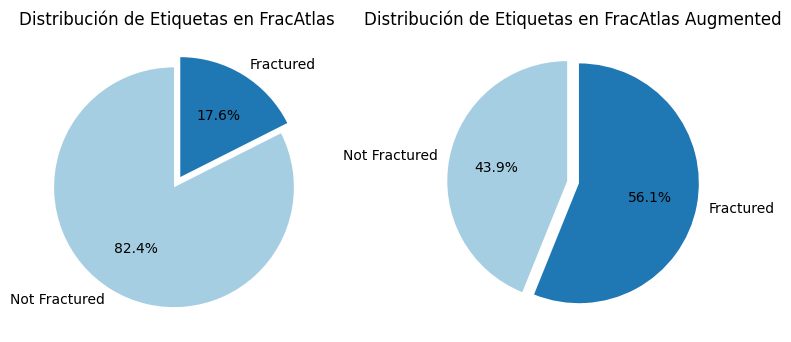

''

In [11]:
labels3, counts3 = np.unique(images_augmented, return_counts=True)
labels3 = [label_map[label] for label in labels3]
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

explode1 = [0.05] * len(labels1)
explode2 = [0.05] * len(labels2)

# Gráfico 1
axes[0].pie(
    counts1, labels=labels1, autopct='%1.1f%%', startangle=90,
    explode=explode1, colors=plt.cm.Paired.colors
)
axes[0].set_title("Distribución de Etiquetas en FracAtlas")

# Gráfico 2
axes[1].pie(
    counts3, labels=labels3, autopct='%1.1f%%', startangle=90,
    explode=explode1, colors=plt.cm.Paired.colors
)
axes[1].set_title("Distribución de Etiquetas en FracAtlas Augmented")

plt.tight_layout()
plt.show()
;

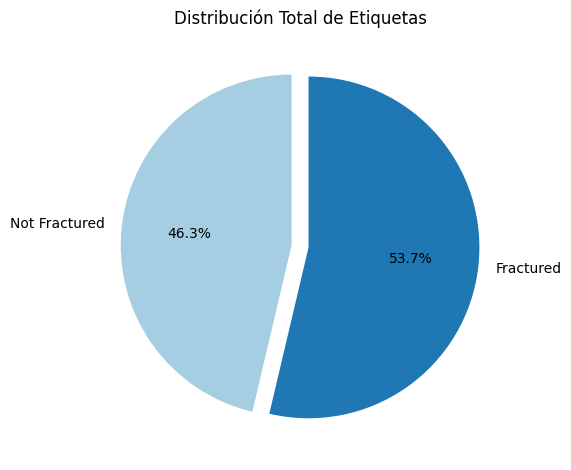

In [12]:
total = np.concatenate([train_labels_f, val_labels_f, test_labels_f,train_labels, val_labels, test_labels])
labelst, countst = np.unique(total, return_counts=True)
labelst = [label_map[label] for label in labelst]
plt.pie(
    countst, labels=labelst, autopct='%1.1f%%', startangle=90,
    explode=explode1, colors=plt.cm.Paired.colors
)
plt.title("Distribución Total de Etiquetas")
plt.tight_layout()
plt.show();


In [13]:
np.unique(total, return_counts=True)

(array([0, 1]), array([5821, 6748], dtype=int64))